# Generative Adversarial Network(GAN)


https://medium.com/datadriveninvestor/generative-adversarial-network-gan-using-keras-ce1c05cfdfd3


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

# 1. MNIST Dataset

The MNIST database is a well known dataset that contains thousands of handwritten digits for machine learning purpose.

## 1.1 Load MNIST dataset from tensorflow library
When we load the dataset below, X_train and X_test will contain the images, and y_train and y_test will contain the digits that those images represent.

In [0]:
#(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
#print("X_train", X_train.shape)
#print("y_train", y_train.shape)
#print("X_test", X_test.shape)
#print("y_test", y_test.shape)


In [68]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)
(X_train, y_train,X_test, y_test)=load_data()
print(X_train.shape)

(60000, 784)


## 1.2 Pre-process the data

In [0]:
#X_train = X_train.astype(np.float32).reshape(X_train.shape[0], height, width, channels)
#X_test = X_test.astype(np.float32).reshape(X_test.shape[0], height, width, channels)
#input_shape = (height, width, 1)

# 2. Build Generative Adversarial Network(GAN)

## 2.1 Build a Generator

In [0]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [71]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator
  
theGenerator = create_generator()
theGenerator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 784)               803600    
Total para

## 2.2 Build a Discriminator

In [72]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator
  
theDiscriminator = create_discriminator()
theDiscriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 256)               131328    
__________

## 2.3 Build the GAN by connecting the Generator and Discriminator

In [73]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
  
theGan = create_gan(theDiscriminator, theGenerator)
theGan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_9 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_10 (Sequential)   (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


# 3. Training the GAN

## 3.1 Visualize the original images and generated images

In [0]:
def plot_generated_images(epoch, generator, examples=4, dim=(2,2), figsize=(5,5)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='binary')
        plt.axis('off')
    plt.tight_layout()
    #plt.savefig('gan_generated_image %d.png' %epoch)

In [0]:
import numpy as np
from IPython.display import SVG, display
from PIL import Image

def invert_image(img):
    return( np.invert(img)  )

  
def denomalize_image(img, invert=False):
    if img.dtype is np.dtype(np.float32):
      image = img * 255
      image = image.astype('uint8')
    else:
      image = img
    
    if invert == True:
      image = invert_image( image )

    return( image )
    

def init_display(img, zoom=2):
    height, width = img.shape
    img_array=denomalize_image(img, invert=True)
    img_disp = Image.fromarray(img_array,mode='P')
    if zoom == 1:
      out = display(img_disp, display_id=True)
    else:
      out = display(img_disp.resize((width*zoom,height*zoom)), display_id=True)
    return( out )


def update_display(out, img, zoom=2):
    height, width = img.shape
    img_array=denomalize_image(img, invert=True)
    img_disp = Image.fromarray(img_array,mode='P')
    if zoom == 1:
      out.update(img_disp)
    else:
      out.update(img_disp.resize((width*zoom,height*zoom)))


      
def plot_output( epoch, generator, examples=16, initial=False, out=None ):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples,28,28)
    plot_image = np.concatenate(generated_images, axis = 1)
    if initial == False:
      update_display(out, plot_image)
    else:
      output = init_display(plot_image)
      return( output )
    

def plot_sample( sample ):
    plot_image = np.concatenate(sample.reshape(sample.shape[0],28,28), axis = 1)
    output = init_display(plot_image)
    return( output )
        
    
    

## 3.2 Train the GAN

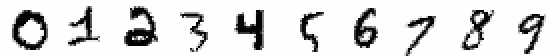

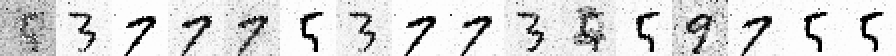

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 1


  9%|▉         | 6/64 [00:00<00:01, 52.21it/s]

Epoch 2


  9%|▉         | 6/64 [00:00<00:01, 52.71it/s]

Epoch 3


  9%|▉         | 6/64 [00:00<00:01, 55.03it/s]

Epoch 4


  9%|▉         | 6/64 [00:00<00:01, 51.92it/s]

Epoch 5


  9%|▉         | 6/64 [00:00<00:01, 54.20it/s]

Epoch 6


  9%|▉         | 6/64 [00:00<00:01, 53.77it/s]

Epoch 7


  9%|▉         | 6/64 [00:00<00:01, 55.56it/s]

Epoch 8


  9%|▉         | 6/64 [00:00<00:01, 51.46it/s]

Epoch 9


  9%|▉         | 6/64 [00:00<00:01, 54.86it/s]

Epoch 10


  9%|▉         | 6/64 [00:00<00:01, 52.99it/s]

Epoch 11


  9%|▉         | 6/64 [00:00<00:01, 54.10it/s]

Epoch 12


  9%|▉         | 6/64 [00:00<00:01, 52.56it/s]

Epoch 13


  9%|▉         | 6/64 [00:00<00:01, 50.28it/s]

Epoch 14


  9%|▉         | 6/64 [00:00<00:01, 56.12it/s]

Epoch 15


  9%|▉         | 6/64 [00:00<00:01, 52.60it/s]

Epoch 16


  9%|▉         | 6/64 [00:00<00:01, 52.89it/s]

Epoch 17


  9%|▉         | 6/64 [00:00<00:01, 54.88it/s]

Epoch 18


  9%|▉         | 6/64 [00:00<00:01, 56.47it/s]

Epoch 19


  8%|▊         | 5/64 [00:00<00:01, 49.81it/s]

Epoch 20


  9%|▉         | 6/64 [00:00<00:01, 54.19it/s]

Epoch 21


  9%|▉         | 6/64 [00:00<00:01, 54.77it/s]

Epoch 22


  9%|▉         | 6/64 [00:00<00:01, 52.47it/s]

Epoch 23


  9%|▉         | 6/64 [00:00<00:01, 54.74it/s]

Epoch 24


  9%|▉         | 6/64 [00:00<00:01, 54.26it/s]

Epoch 25


  9%|▉         | 6/64 [00:00<00:01, 51.39it/s]

Epoch 26


  9%|▉         | 6/64 [00:00<00:01, 52.97it/s]

Epoch 27


  9%|▉         | 6/64 [00:00<00:01, 54.98it/s]

Epoch 28


  9%|▉         | 6/64 [00:00<00:01, 53.80it/s]

Epoch 29


  9%|▉         | 6/64 [00:00<00:01, 55.08it/s]

Epoch 30


  9%|▉         | 6/64 [00:00<00:01, 54.42it/s]

Epoch 31


  9%|▉         | 6/64 [00:00<00:01, 55.23it/s]

Epoch 32


  9%|▉         | 6/64 [00:00<00:01, 54.16it/s]

Epoch 33


  9%|▉         | 6/64 [00:00<00:01, 55.35it/s]

Epoch 34


  9%|▉         | 6/64 [00:00<00:01, 52.52it/s]

Epoch 35


  9%|▉         | 6/64 [00:00<00:01, 55.29it/s]

Epoch 36


  9%|▉         | 6/64 [00:00<00:01, 56.47it/s]

Epoch 37


  9%|▉         | 6/64 [00:00<00:01, 52.37it/s]

Epoch 38


  9%|▉         | 6/64 [00:00<00:01, 55.21it/s]

Epoch 39


  9%|▉         | 6/64 [00:00<00:01, 55.11it/s]

Epoch 40


  9%|▉         | 6/64 [00:00<00:01, 54.95it/s]

Epoch 41


  9%|▉         | 6/64 [00:00<00:01, 55.95it/s]

Epoch 42


  9%|▉         | 6/64 [00:00<00:01, 51.15it/s]

Epoch 43


  9%|▉         | 6/64 [00:00<00:01, 52.99it/s]

Epoch 44


  9%|▉         | 6/64 [00:00<00:01, 51.66it/s]

Epoch 45


  9%|▉         | 6/64 [00:00<00:01, 51.87it/s]

Epoch 46


  8%|▊         | 5/64 [00:00<00:01, 48.82it/s]

Epoch 47


  9%|▉         | 6/64 [00:00<00:01, 54.19it/s]

Epoch 48


  9%|▉         | 6/64 [00:00<00:01, 55.24it/s]

Epoch 49


  9%|▉         | 6/64 [00:00<00:01, 54.95it/s]

Epoch 50


100%|██████████| 64/64 [00:01<00:00, 53.94it/s]


In [76]:
epochs = 50
batch_size = 64
sample_size = 10

#Pick the sample images -- each one from number 0 to 9
sample = np.empty(shape=10).astype('uint8')
for i in range(0,sample_size):
  sample[i] = np.where(y_train==i)[0][5]

#Show the sample images
sample_image = X_train[sample]
plot_sample( sample_image )


#Display the initial generator generated images
display_output = plot_output( 0, theGenerator, examples=16, initial=True )


#
# Main loop for training the GAN
#
for e in range(1,epochs+1 ):
    print("Epoch %d" %e)
    for _ in tqdm(range(batch_size)):
      
        #generate random noise as an input to initialize the generator
        noise= np.random.normal(0,1, [batch_size, 100])
        generated_images = theGenerator.predict(noise)

        # Make the ground truth images from the sample images, 
        # randomly create them by the number of batch_size 
        #image_batch = X_train[np.random.choice(sample, size=batch_size)]
        image_batch = sample_image

        #Mix the ground truth images with the generated images,
        #and label them 1 for ground truth and 0 for generated ones
        X_gan = np.concatenate([image_batch, generated_images])
        y_gan = np.concatenate([np.ones(image_batch.shape[0]), np.zeros(generated_images.shape[0])])
        y_gan = y_gan.astype(np.float32)

        #First train the discriminator. 
        theDiscriminator.trainable=True
        theDiscriminator.train_on_batch(X_gan, y_gan)

        #Tricking the noised input of the Generator as real data
        noise= np.random.normal(0,1, [batch_size, 100])
        y_gen = np.ones(batch_size)

        # During the training of gan, 
        # the weights of discriminator should be fixed. 
        #We can enforce that by setting the trainable flag
        theDiscriminator.trainable=False

        #training  the GAN by alternating the training of the Discriminator 
        #and training the chained GAN model with Discriminator’s weights freezed.
        theGan.train_on_batch(noise, y_gen)

    if e == 1 or e % 2 == 0:
        #plot_generated_images(e, generator)
        plot_output( e, theGenerator, out=display_output )



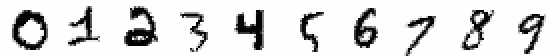

<DisplayHandle display_id=0e42cb95fd1f80544bdc74350fd1ac84>

In [77]:
#Pick the sample images
sample = np.empty(shape=10).astype('uint8')
for i in range(0,10):
  sample[i] = np.where(y_train==i)[0][5]

image_batch = X_train[sample]
plot_sample( image_batch )


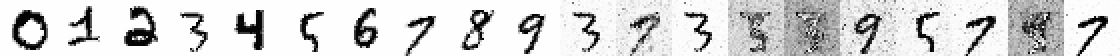

<DisplayHandle display_id=c730f2bae5e3d3118cdd2b80d5049db5>

In [78]:
plot_sample( X_gan[0:20,:] )

In [79]:
y_gan

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)